#### Import packages and initialize the h2o application server

In [1]:
import h2o
import pandas as pd
import matplotlib.pyplot as plt
import time

from h2o.automl import H2OAutoML
from IPython.core.display import display, HTML

h2o.init(log_level="INFO")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.1" 2021-10-19; OpenJDK Runtime Environment (build 17.0.1+12); OpenJDK 64-Bit Server VM (build 17.0.1+12, mixed mode)
  Starting server from /home/jeff/code/findChurn/env/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmprbuel7ya
  JVM stdout: /tmp/tmprbuel7ya/h2o_jeff_started_from_python.out
  JVM stderr: /tmp/tmprbuel7ya/h2o_jeff_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,2 months and 8 days
H2O_cluster_name:,H2O_from_python_jeff_ybbpsa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.828 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


#### Load the data

In [2]:
historical_outcomes = pd.read_json('Telco_Churn_historical_outcomes.json')

history = h2o.H2OFrame(historical_outcomes)

all_columns = history.columns

# create a list of column names that should not be used as predictors (IDs, row counts, and the response column)
ignore_columns = ["customerID"]
for i in all_columns:
    if i[0:12] == "Row Count - ":
        ignore_columns.append(i)
print("Ignore Fields: " + str(ignore_columns))

# define the response (target) field
response = "Churn"

print(history.describe()) 

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Ignore Fields: ['customerID']
Rows:4226
Cols:21




,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
type,string,enum,int,enum,enum,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,real,real,enum
mins,NaN,,0.0,,,0.0,,,,,,,,,,,,,18.25,18.8,
mean,NaN,,0.16303833412210128,,,32.47633696166593,,,,,,,,,,,,,64.87386417416002,2310.916362559243,
maxs,NaN,,1.0,,,72.0,,,,,,,,,,,,,118.75,8684.8,
sigma,NaN,,0.3694443573864723,,,24.743264620298163,,,,,,,,,,,,,30.206467961311827,2294.219370612503,
zeros,0,,3537,,,6,,,,,,,,,,,,,0,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0
0,9018-PCIOK,Female,0.0,No,No,55.0,Yes,No,DSL,No,Yes,Yes,No,No,Yes,Two year,Yes,Mailed check,64.75,3617.1,No
1,6732-FZUGP,Female,0.0,No,No,47.0,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,No,One year,No,Credit card (automatic),94.9,4615.25,No
2,0623-EJQEG,Male,0.0,No,No,65.0,Yes,Yes,Fiber optic,Yes,No,No,Yes,No,Yes,One year,No,Electronic check,93.55,6069.25,No


None


#### Define model inputs, split into training and validation sets, train & validate the model

AutoML progress: |
09:13:03.900: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%
model build time (seconds): 46


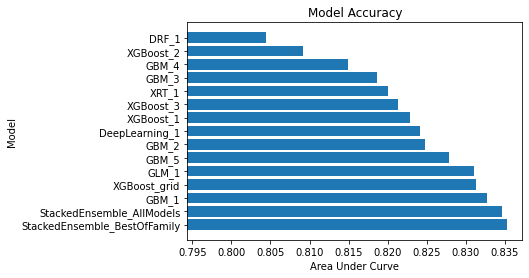

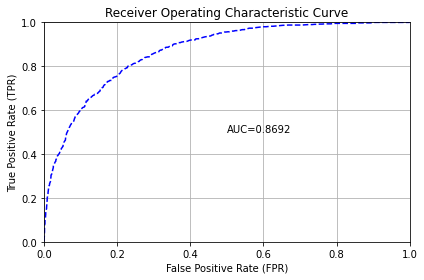


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3439355465392644: 


,,No,Yes,Error,Rate
0,No,2059.0,431.0,0.1731,(431.0/2490.0)
1,Yes,246.0,665.0,0.27,(246.0/911.0)
2,Total,2305.0,1096.0,0.1991,(677.0/3401.0)


In [3]:
runtime = int(input("How long should we allow the model to build? (in seconds)  "))

# define the predictors (include factors)
predictors = set(all_columns).difference(ignore_columns)
predictors = list(predictors)

for i in predictors:
    if i == response:
        predictors.remove(i)
        
# define training and validation splits
history[response] = history[response].asfactor()  # for binary classification, response should be cast as a factor
train, valid = history.split_frame(ratios=[.8], seed=1234)

# build the model: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
m = H2OAutoML(max_runtime_secs=runtime, max_models=40, seed=5678)

start_time = time.time()
m.train(x=predictors, y=response, training_frame=train, validation_frame=valid)

finish_time = time.time()
print("model build time (seconds): " + str(int(finish_time - start_time)))

# validate model accuracy using the leaderboard
lb = m.leaderboard.as_data_frame()
lb.sort_values(by="auc", ascending=True)
use_models = lb["model_id"].tolist()
use_performance = lb["auc"].tolist()

# iterate thru the model names for readability
for index,item in enumerate(use_models):
    use_models[index] = use_models[index][:use_models[index].replace("_", " ", 1).find("_")]  # trim the model name starting with the second underscore

plt.barh(use_models, use_performance)
plt.xlim(min(use_performance)-.01, max(use_performance)+.002)
plt.title("Model Accuracy")
plt.xlabel("Area Under Curve")
plt.ylabel("Model")
display(HTML("<a href='http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science.html#supervised'>Model Descriptions</a>"))
plt.show()

m_performance = m.leader.model_performance()
m_performance.plot(type="roc")

print(m.leader.confusion_matrix())

#### Save the leader model and shut down the h2o application server

In [4]:
h2o.save_model(m.leader, '.', True, export_cross_validation_predictions=False, filename='churn_model')  # https://docs.h2o.ai/h2o/latest-stable/h2o-docs/save-and-load-model.html
h2o.cluster().shutdown()

H2O session _sid_b253 closed.
